# Patching the grids together

### helper routines and constants

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#Constants
PI_180 = np.pi/180.
Re = 6.378e6

#utility function to plot grids
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r'):
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
#plot_mesh_in_latlon(lams,phis,stride=16)

def cut_below(lam,phi,lowerlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>lowerlat):
            break
    jmin=j
    print("jmin",jmin)
    return lam[jmin:,:], phi[jmin:,:]

def cut_above(lam,phi,upperlat):
    nj,ni = lam.shape
    for j in range(0,nj):
        if(phi[j,0]>upperlat):
            break
    jmax=j
    print("jmax",jmax)
    return lam[0:jmax,:], phi[0:jmax,:]

def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', lowerlat=None, upperlat=None):
    if lowerlat is not None:
        lam,phi = cut_below(lam,phi,lowerlat=lowerlat)
        
    if upperlat is not None:
        lam,phi = cut_above(lam,phi,upperlat=upperlat)
        
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
        
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color)
#plt.figure(figsize=(6,6))
#plot_mesh_in_xyz(lams, phis, stride=20)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

def generate_grid_metrics(x,y,axis_units='degrees'):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':            
      metric=1.e3
    if  axis_units == 'degrees':                        
      metric=Re*PI_180
    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))      
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    dx = metric*metric*(dy_i*dy_i + dx_i*dx_i*np.cos(ymid_i*PI_180)*np.cos(ymid_i*PI_180))
    dx = np.sqrt(dx)
    dy = metric*metric*(dy_j*dy_j + dx_j*dx_j*np.cos(ymid_j*PI_180)*np.cos(ymid_j*PI_180))
    dy = np.sqrt(dy)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    area=dx[:-1,:]*dy[:,:-1]    
    angle_dx=np.zeros((nytot,nxtot))
    angle_dx = np.arctan2(dy_i,dx_i)/PI_180      
    return dx,dy,area,angle_dx


def write_nc(x,y,dx,dy,area,angle,axis_units='degrees',fnam=None,format='NETCDF3_CLASSIC'):
    import netCDF4 as nc

    if fnam is None:
      fnam='supergrid.nc'
    f=nc.Dataset(fnam,'w',format=format)
    dims=[]
    vars=[]
    nytot,nxtot = y.shape
    nyp=f.createDimension('nyp',nytot)
    nxp=f.createDimension('nxp',nxtot)
    ny=f.createDimension('ny',nytot-1)
    nx=f.createDimension('nx',nxtot-1)    
    yv=f.createVariable('y','f8',('nyp','nxp'))
    xv=f.createVariable('x','f8',('nyp','nxp'))    
    yv.units=axis_units
    xv.units=axis_units 
    yv[:]=y
    xv[:]=x
    dyv=f.createVariable('dy','f8',('ny','nxp'))
    dyv.units='meters'
    dyv[:]=dy
    dxv=f.createVariable('dx','f8',('nyp','nx'))
    dxv.units='meters'
    dxv[:]=dx
    areav=f.createVariable('area','f8',('ny','nx'))
    areav.units='m2'
    areav[:]=area
    anglev=f.createVariable('angle_dx','f8',('nyp','nxp'))
    anglev.units='degrees'
    anglev[:]=angle            
    f.sync()
    f.close()

def generate_latlon_grid(lni,lnj,llon0,llen_lon,llat0,llen_lat):
    llonSP = llon0 + np.arange(lni+1) * llen_lon/lni
    llatSP = llat0 + np.arange(lnj+1) * llen_lat/lnj
    llamSP = np.tile(llonSP,(lnj+1,1)) 
    lphiSP = np.tile(llatSP.reshape((lnj+1,1)),(1,lni+1)) 
    return llamSP,lphiSP


### grid parameters

In [33]:
# Specify the grid properties
# All
# Specify the desired resolution
degree_resolution_inverse = 4 #quarter degree grid
refine=2    # Set to 2 for supergrid
lenlon=360  # global longitude range
lon0=-300.  # Starting longitude (longitude of the Northern bipoles)
Ni = lenlon*refine*degree_resolution_inverse

#Mercator grid
phi_s_Merc, phi_n_Merc = -66.85954724706843, 64.0589597296948
#Actual phi range: phi_s,phi_n= [-66.85954725  64.05895973]

#Southern grid
Nj_SO=110*refine
lat0_SO=-78.0
lenlat_SO = phi_s_Merc-lat0_SO 

#Southern cap
Nj_scap=80*refine
lon_dp=100.0   # longitude of the displaced pole 
r_dp=0.20
doughnut=0.12

#Northern bipolar cap
Nj_ncap=119*refine
lon_bp=lon0 # longitude of the displaced pole(s)
lat0_bp=phi_n_Merc #61.247692871618455 #mercator.y.max()
lenlat_bp=90.0-lat0_bp


### Implementation of Mercator

y*= [-727  673] nj= 1400
Actual phi range: phi_s,phi_n= [-66.85954725  64.05895973]
Grid = [-66.85954725 -66.81037464 -66.76110332 ...  63.94938346  64.00422531
  64.05895973]
jmin 979


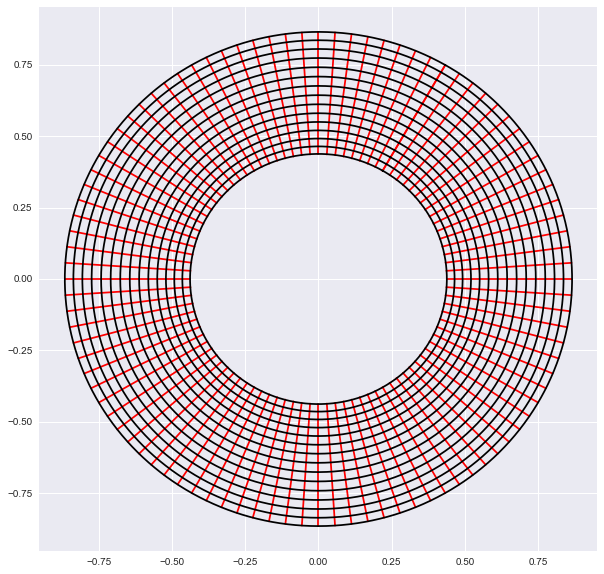

In [34]:
def y_mercator(Ni, phi):
    """Equation (1)"""
    R = Ni / (2 * np.pi)
    return R * ( np.log( (1.0 + np.sin(phi) ) / np.cos(phi)) )
def phi_mercator(Ni, y):
    """Equation (2)"""
    R = Ni / (2 * np.pi)
    return np.arctan( np.sinh(y/R) ) * (180/np.pi) # Converted to degrees
def y_mercator_rounded(Ni, phi):
    y_float = y_mercator(Ni, phi)
    return ( np.sign(y_float) * np.ceil( np.abs(y_float) ) ).astype(int)

def generate_mercator_grid(Ni,phi_s,phi_n,lon0_M,lenlon_M):
    # Diagnose nearest integer y(phi range)
    y_star = y_mercator_rounded(Ni, np.array([phi_s*PI_180,phi_n*PI_180]))
    Nj=y_star[1]-y_star[0]
    print( 'y*=',y_star, 'nj=', Nj )
    print( 'Actual phi range: phi_s,phi_n=', phi_mercator(Ni, y_star) )
    phi_M = phi_mercator(Ni, np.arange(y_star[0],y_star[1]+1)) 
    print( 'Grid =', phi_M )
#    if(y_star[1]-y_star[0] != Nj):
#        print("Error: the Mercator construct did not produce the expected number of j points ",Nj)
    y_grid_M = np.tile(phi_M.reshape(Nj+1,1),(1,Ni+1))
    lam_M = lon0_M + np.arange(Ni+1) * lenlon_M/Ni
    x_grid_M = np.tile(lam_M,(Nj+1,1)) 
    return x_grid_M,y_grid_M
    

#generate the grid
lamMerc,phiMerc = generate_mercator_grid(Ni,phi_s_Merc,phi_n_Merc,lon0,lenlon)    
#### Why N_j comes out of the above but is needed as an input to MIDAS?

#generate the metrics
dxMerc,dyMerc,areaMerc,angleMerc = generate_grid_metrics(lamMerc,phiMerc,axis_units='degrees')

#write the grid file
write_nc(lamMerc,phiMerc,dxMerc,dyMerc,areaMerc,angleMerc,axis_units='degrees',fnam='mercator_new.nc')

#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamMerc,phiMerc, stride=30,lowerlat=30)

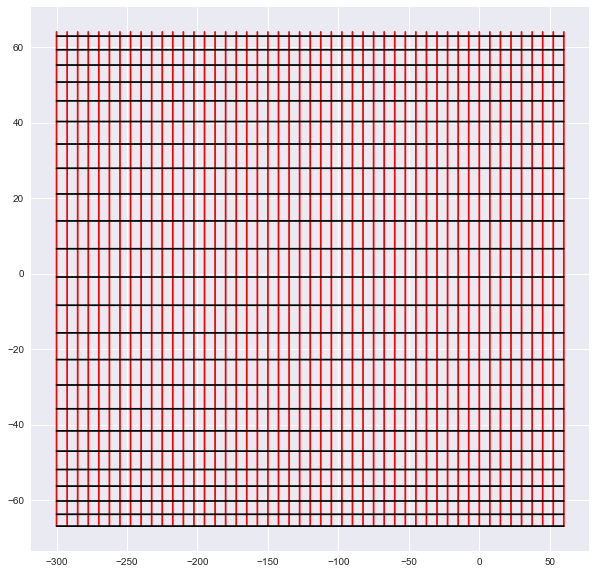

In [35]:
plt.figure(figsize=(10,10))
plot_mesh_in_latlon(lamMerc,phiMerc, stride=60)

## Implementation of bipolar cap

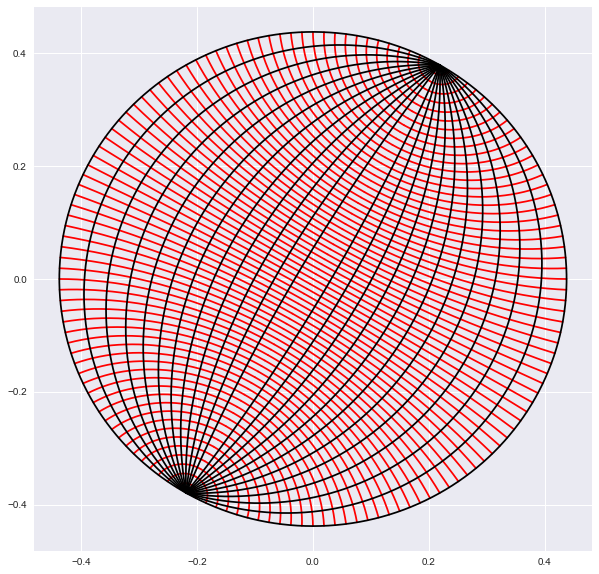

In [36]:
def bipolar_cap(lamg,phig,lat0_p,lon_p):
    rp=np.tan(0.5*(90-lat0_p)*PI_180)

    #Simplify  the formulas to avoid division by zero
    #alpha  = np.cos((lamg-lon_p)*PI_180) 
    alpha2 = (np.cos((lamg-lon_p)*PI_180))**2
    #beta = -np.cotan(phig*PI_180)
    beta2_inv = (np.tan(phig*PI_180))**2
    
    A=np.sqrt(1-alpha2)*np.sin(phig*PI_180) #Actually two equations  +- |A|
    
    B=np.sqrt((1-alpha2)/(1+alpha2*beta2_inv)) #Actually two equations  +- |B|

    phic = np.arcsin(A)/PI_180
    lamc = np.arcsin(B)/PI_180 

    ##But this equation accepts 4 solutions for a given B, {l, 180-l, l+180, 360-l } 
    ##We have to pickup the "correct" root. 
    ##One way is simply to demand lamc to be continuous with lam on the equator phi=0
    ##I am sure there is a more mathematically concrete way to do this.
    lamc = np.where((lamg-lon_p>90)&(lamg-lon_p<=180),180-lamc,lamc)
    lamc = np.where((lamg-lon_p>180)&(lamg-lon_p<=270),180+lamc,lamc)
    lamc = np.where((lamg-lon_p>270),360-lamc,lamc)
    lams = lamc + lon_p

    ##Project back onto the larger (true) sphere so that the projected equator shrinks to latitude \phi_P=lat0_tp
    ##then we have tan(\phi_s'/2)=tan(\phi_p'/2)tan(\phi_c'/2)

    #phis = 90 - 2 * np.arctan(rp * np.tan(0.5*(90-phic)*PI_180))/PI_180
    #or
    chic = np.arccos(A)
    phis = 90 - 2 * np.arctan(rp * np.tan(chic/2))/PI_180
    return lams,phis


#Define a (lon,lat) coordinate on the Northern hemisphere of the globe sphere

sp_long = lon_bp + np.arange(Ni+1) * lenlon/Ni 
sp_latg = 0 + np.arange(Nj_ncap+1) * 90/Nj_ncap
long = np.tile(sp_long,(Nj_ncap+1,1)) 
latg = np.tile(sp_latg.reshape((Nj_ncap+1,1)),(1,Ni+1))


lams_new,phis_new = bipolar_cap(lamg=long,phig=latg,lat0_p=lat0_bp,lon_p=lon_bp)

plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_new, phis_new, stride=20)

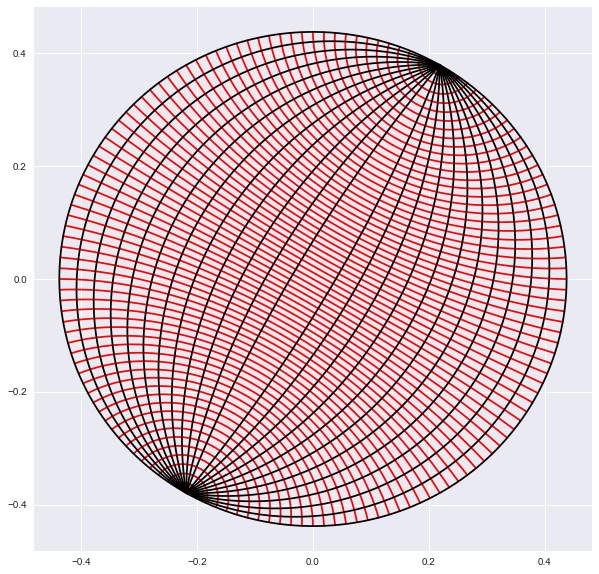

In [37]:
def bp_lam(x,y,bpeq,rp):
    """bp_lam = ((90-y)/(90-lat_join))*90
       invert Murray's eqn. 5b with phic=0 to place point at specified geo. lat """
    bp_lam = 2.*np.arctan(np.tan((0.5*np.pi-y*PI_180)/2)/rp)/PI_180
    bp_lam = np.where(mdist(x,bpeq)<90.,-bp_lam, bp_lam)
    return bp_lam    

def bp_phi(x,y,bpsp,bpnp):
    bps = mdist(x,bpsp)
    bpn = mdist(x,bpnp)
    bp_phi = np.where(bps<90,-90+bps,90-bpn)
    return bp_phi

rp=np.tan(0.5*(90-lat0_bp)*PI_180) #Murray section 2.2 before Eq(6) r_p=tan(\phi_P\prime /2) 
                                                   #where \phi_P is the latitude of the bounding parrallel lat0

lamc_fms = bp_lam(lon_cap,lat_cap,lon_bp+90,rp) 
phic_fms = bp_phi(lon_cap,lat_cap,lon_bp,lon_bp+180)
lams_fms = lon_bp + 90*0 - np.arctan2(np.sin(lamc_fms*PI_180),np.tan(phic_fms*PI_180))/PI_180 #eqn.5a
#Note the *0:          |
#The original grid is rotated 90 degrees compared to both MIDAS and new

chic_fms = np.arccos(np.cos(lamc_fms*PI_180)*np.cos(phic_fms*PI_180)) #eqn.6
phis_fms = 90 - 2 * np.arctan(rp*np.tan(chic_fms/2))/PI_180


#plt.plot(phis_fms);
#plot_grid( lams_fms,phis_fms, lam_cap,phi_cap,lon0=lon_p, lat0=lat_p, dlat=10, dlon=5)
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_fms, phis_fms, stride=20)

## Patching together the Mercator and bipolar 

jmin 1331


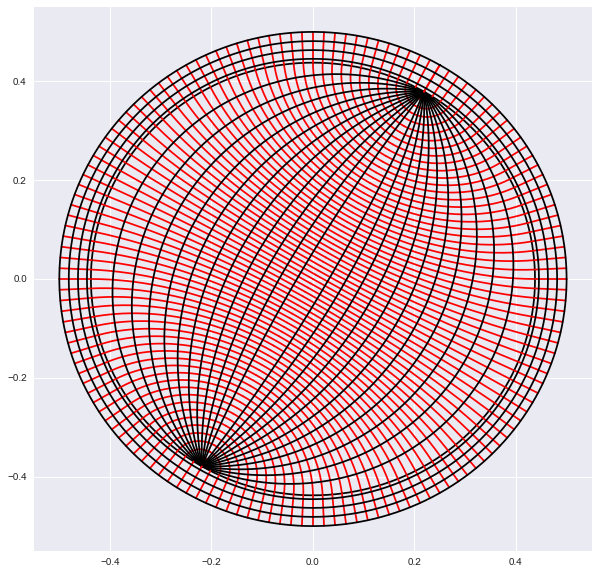

In [38]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_new, phis_new, stride=20)
plot_mesh_in_xyz(lamMerc,phiMerc, stride=20,lowerlat=60)


jmin 1331


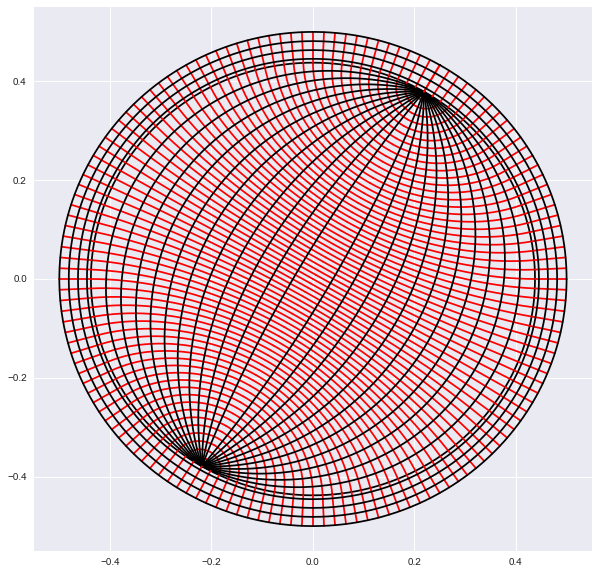

In [39]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lams_fms, phis_fms, stride=20)
plot_mesh_in_xyz(lamMerc,phiMerc, stride=20,lowerlat=60)


## Southern Ocean and Cap

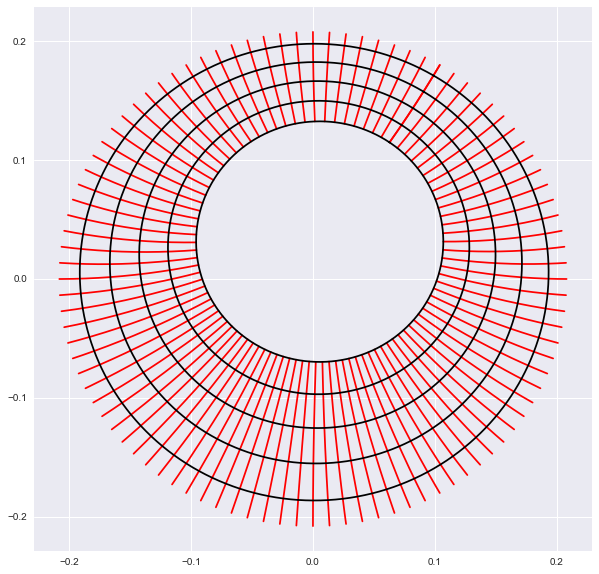

In [40]:
def displaced_pole_cap(lon_grid,lat_grid,lam_pole,r_pole,lat_joint,excluded_fraction=None):

    #Projection from center of globe to plane tangent at south pole
    r_joint = np.tan((90+lat_joint)*PI_180) 
    z_0= r_pole * np.exp(1j*lam_pole*PI_180) 

    r = np.tan((90+lat_grid) *PI_180)/r_joint

    #Find the theta that has matching resolution at the unit circle with longitude at the joint
    #This is a conformal transformation the unit circle (inverse to the one below)
    e2itheta = np.exp(1j*lon_grid*PI_180) 
    e2ithetaprime = (e2itheta + z_0)/(1. + np.conj(z_0)*e2itheta)

    #Conformal map to displace pole from r=0 to r=r_dispole
    z=r*e2ithetaprime
    w=(z-z_0)/(1-np.conj(z_0)*z)
    
    #Inverse projection from tangent plane back to sphere
    lamcDP = np.angle(w, deg=True)
    rw=np.absolute(w)
    phicDP = -90+np.arctan(rw*r_joint)/PI_180
    if excluded_fraction is not None:
        ny,nx = lon_grid.shape 
        jmin=np.ceil(excluded_fraction*ny)
        jmin=jmin+np.mod(jmin,2)
        jmint = int(jmin)
        return lamcDP[jmint:,:], phicDP[jmint:,:]
    else:
        return lamcDP,phicDP

#Southern Ocean    
lamSO,phiSO = generate_latlon_grid(Ni,Nj_SO,lon0,lenlon,lat0_SO,lenlat_SO)

#Southern Cap
x=lamSO[0,:]
y=np.linspace(-90.,0.5*(lat0_SO-90.0),Nj_scap//8)
y=np.concatenate((y,np.linspace(y.max(),lat0_SO,7*Nj_scap//8+1)))
X1,Y1=np.meshgrid(x,y)
#print("X1.shape,Y1.shape ",X1.shape,Y1.shape)
    
lamc_DP,phic_DP = displaced_pole_cap(X1,Y1,lam_pole=-lon_dp,r_pole=r_dp,lat_joint=lat0_SO,
                                     excluded_fraction=doughnut)   
    
#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamc_DP,phic_DP, stride=30)

jmax 124


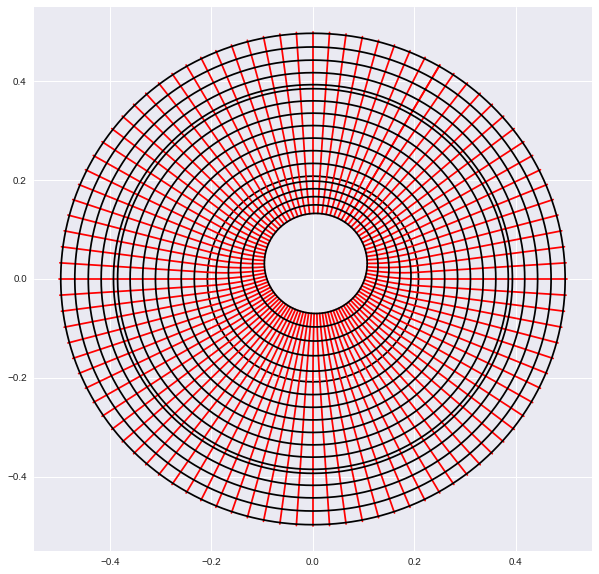

In [50]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamSO,phiSO, stride=30)
plot_mesh_in_xyz(lamc_DP,phic_DP, stride=30)
plot_mesh_in_xyz(lamMerc,phiMerc, stride=30, upperlat=-60)
